In this notebook, we will try to build a very simple model to predict the outcome of tennis matched.  This is an ELO model.  Specifically, we will model

$$p(y_1) = \sigma(\beta_1 - \beta_2)$$, where $$\beta_1$$ and $$\beta_2$$ are coefficients for players 1 and 2 respectively

In [1]:
from infra.defs import DATA_DIR
import pandas as pd
import os

match_result_dir = os.path.join(DATA_DIR, 'match_results')

df = pd.concat([
    pd.read_csv(os.path.join(match_result_dir, f)) for f in os.listdir(match_result_dir)
])

In [2]:
df.rename(columns={x: x.lower() for x in df.columns}, inplace=True)

In [3]:
# Drop rows with no result
import numpy as np

df.dropna(subset=['winner', 'loser'], inplace=True)
df['wrank'].replace('NR', np.nan, inplace=True)
df['lrank'].replace('NR', np.nan, inplace=True)
df['wrank'] = df['wrank'].astype(float)
df['lrank'] = df['lrank'].astype(float)

In [4]:
df.shape

(50784, 59)

50k matches to work with

In [5]:
df['match_id'] = range(df.shape[0])

In [6]:
# Convert dates to datetimes
df['date'] = pd.to_datetime(df['date']).astype(pd.Timestamp)

#### Explore Player Frequencies

In [7]:
df['winner'] = df['winner'].map(lambda x: x.strip())
df['loser'] = df['loser'].map(lambda x: x.strip())
player_set = set(df['winner']) | set(df['loser'])
n_players = len(player_set)
n_players

1396

In [8]:
sorted(player_set)

['Abdulla M.',
 'Abel M.',
 'Acasuso J.',
 'Adaktusson J.',
 'Agaev E.',
 'Agassi A.',
 'Agenor R.',
 'Ager J.',
 'Agostinelli B.',
 'Aguilar J.',
 'Ahouda A.',
 'Al Ghareeb M.',
 'Al Khulaifi N.G.',
 'Al Mutawa J.',
 'Al-Alawi S.K.',
 'Al-Ghareeb M.',
 'Alami K.',
 'Alawadhi O.',
 'Albert M.',
 'Albot R.',
 'Alcaide G.',
 'Aldi F.',
 'Ali Mutawa J.M.',
 'Allegro Y.',
 'Almagro N.',
 'Alonso J.',
 'Altamirano C.',
 'Altmaier D.',
 'Alund M.',
 'Alvarez E.',
 'Alves T.',
 'Amritraj P.',
 'Ancic I.',
 'Ancic M.',
 'Andersen J.',
 'Andersen J.F.',
 'Anderson A.',
 'Anderson K.',
 'Anderson O.',
 'Andersson H.',
 'Andreev A.',
 'Andreev I.',
 'Andreozzi G.',
 'Androic T.',
 'Andujar P.',
 'Aragone J.',
 'Aranguren J.M.',
 'Arazi H.',
 'Arguello F.',
 'Armando H.',
 'Arnaboldi A.',
 'Arnold L.',
 'Arquez P.',
 'Arthurs W.',
 'Artunedo Martinavarro A.',
 'Arvidsson I.',
 'Ascione A.',
 'Ascione T.',
 'Auckland J.',
 'Auger-Aliassime F.',
 'Authom M.',
 'Awadhy O.',
 'Ayala D.',
 'Azzaro L.',

1396 total players.  Let's look at player frequency:

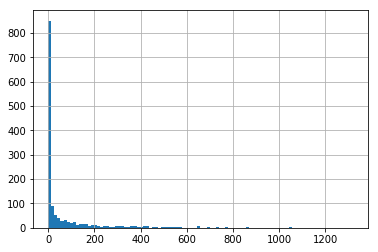

In [9]:
%matplotlib inline
all_players = pd.Series(df['winner'].tolist() + df['loser'].tolist())
all_players.value_counts().hist(bins=100)

There is clearly a long tail.  There are certain players that have played a lot of matches over this time period, and lots of players with very few

In [10]:
all_players.value_counts().value_counts().head()

1    314
2    163
3     84
4     59
5     49
dtype: int64

In [11]:
all_players.value_counts().head(20)

Federer R.          1318
Nadal R.            1051
Ferrer D.           1042
Djokovic N.          919
Berdych T.           888
Youzhny M.           865
Robredo T.           864
Lopez F.             858
Verdasco F.          854
Murray A.            806
Davydenko N.         794
Gasquet R.           773
Roddick A.           773
Kohlschreiber P.     730
Hewitt L.            727
Simon G.             724
Wawrinka S.          701
Nieminen J.          697
Haas T.              691
Ferrero J.C.         683
dtype: int64

The players who appear most often are the best players...

#### Get player indices

In [12]:
player_idx_dict = dict(list(enumerate(player_set)))
player_mapping = {v: k for k, v in player_idx_dict.iteritems()}

In [13]:
n_players = len(player_mapping)
n_players

1396

In [14]:
df['winner_idx'] = df['winner'].map(lambda x: player_mapping[x])
df['loser_idx'] = df['loser'].map(lambda x: player_mapping[x])

#### Set up training data

First, we'll just try training on everything in this time period and see what happens.  Later, we will split into train and test sets and figure out appropriate discounting, etc.

In [49]:
from scipy.sparse import csc_matrix, hstack
import numpy as np


N_PLAYERS = len(player_mapping)

def _get_sparse_X(df):
    n = df.shape[0]
    p1_data = np.ones(n)
    p1_row = np.arange(n)
    p1_col = df['p1_idx'].values

    p2_data = -np.ones(n)
    p2_row = np.arange(n)
    p2_col = df['p2_idx'].values

    all_data = np.concatenate([p1_data, p2_data])
    all_row = np.concatenate([p1_row, p2_row])
    all_col = np.concatenate([p1_col, p2_col])

    X = csc_matrix((all_data, (all_row, all_col)), shape=(n, N_PLAYERS))
    return X


def _randomize_result(df):
    df['__chooser__'] = np.random.binomial(1, 0.5, size=df.shape[0])
    df['p1_idx'] = df.apply(
        lambda row: row['winner_idx'] if row['__chooser__'] == 1 else row['loser_idx'],
        axis=1
    )
    df['p2_idx'] = df.apply(
        lambda row: row['winner_idx'] if row['__chooser__'] == 0 else row['loser_idx'],
        axis=1
    )
    df['p1_rank'] = df.apply(
        lambda row: row['wrank'] if row['__chooser__'] == 1 else row['lrank'],
        axis=1
    )
    df['p2_rank'] = df.apply(
        lambda row: row['wrank'] if row['__chooser__'] == 0 else row['lrank'],
        axis=1
    )
    df['y'] = df['__chooser__']
    

def get_X_y(df, include_ranks=False, nan_fill=500.):
    if 'p1_idx' not in df or 'p2_idx' not in df:
        # Shuffle winners and losers so y can have both 0's and 1's.
        _randomize_result(df)
    X = _get_sparse_X(df)
    assert ((X != 0).sum(axis=1) == 2).all()
    if include_ranks:
        ranks = csc_matrix(df[['p1_rank', 'p2_rank']].fillna(nan_fill).values)
        X = hstack([X, ranks])
    return X, df['y'].values

X, y = get_X_y(df, include_ranks=False)
assert ((X > 0).sum(axis=1) == 1).all()
assert ((X < 0).sum(axis=1) == 1).all()

#### Create Logistic Regression with NonZero Prior

I'll start with a zero prior and go from there...

In [150]:
from scipy.optimize import fmin_l_bfgs_b


def sigmoid(x):
    return 1. / (1. + np.exp(-x))

class NonZeroLogit():
    
    def __init__(self, lmbda=0.1, prior=0.):
        self.lmbda = lmbda
        self.prior = prior

    @staticmethod
    def loss(beta, X, y, lmbda, prior, w):
        # Negate likelihood because we lbfgs minimizes
        y_hat = sigmoid(X.dot(beta))
        return -np.sum(w * 
            (y * np.log(y_hat) + (1. - y) * np.log(1. - y_hat))
        ) + lmbda * (beta - prior).transpose().dot(beta - prior) 

    @staticmethod
    def fprime(beta, X, y, lmbda, prior, w):
        y_hat = sigmoid(X.dot(beta))
        return -(X.transpose().dot(w * (y - y_hat))) + lmbda * (beta - prior)
        
    def fit(self, X, y, sample_weight=None):
        self.beta = np.random.normal(size=X.shape[1])  # Initialize randomly
        if sample_weight is None:
            w = np.ones(X.shape[0])
        else:
            w = sample_weight
        result = fmin_l_bfgs_b(
            self.loss,
            x0 = self.beta,
            args = (X, y, self.lmbda, self.prior, w),
            fprime = self.fprime,
            pgtol =  1e-3,
            disp = True
        )
        self.beta = result[0]
        
    def predict_proba(self, X):
        p1 = sigmoid(X.dot(self.beta))
        return np.array([1. - p1, p1]).transpose()
    
    def predict(self, X):
        return (sigmoid(X.dot(self.beta)) > 0.5).astype(int)

In [151]:
nzl = NonZeroLogit(lmbda=1.)
nzl.fit(X, y)
describe_result(nzl.beta).head()

,player_idx,coef,player_name
2,2,3.209133,Djokovic N.
766,766,3.102906,Federer R.
51,51,3.069737,Nadal R.
271,271,2.740289,Murray A.
1198,1198,2.351039,Roddick A.


In [152]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(fit_intercept=False)
logit.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [125]:
def describe_result(coefs):
    coef_df = pd.DataFrame(list(enumerate(coefs[:N_PLAYERS])),
        columns=['player_idx', 'coef']
    )
    coef_df['player_name'] = coef_df['player_idx'].map(lambda x: player_idx_dict[x])
    return coef_df.sort_values(by='coef', ascending=False)

describe_result(logit.coef_[0]).head(20)

,player_idx,coef,player_name
2,2,3.208592,Djokovic N.
766,766,3.102251,Federer R.
51,51,3.068686,Nadal R.
271,271,2.739398,Murray A.
1198,1198,2.350218,Roddick A.
902,902,2.323933,Agassi A.
713,713,2.296632,Del Potro J.M.
1171,1171,2.117015,Tsonga J.W.
1023,1023,2.074879,Hewitt L.
1168,1168,2.026668,Raonic M.


#### Tune Time-Decay and Regularization

There is an argument that we should not be regularizing towards 0.  Players that appear infrequently are probably wors -- they qualify for fewer tournaments and progress to later rounds of tournaments less often.  For now however, we will continue to regularize towards 0.  Here, we investigate the following:

* What time decay weight is most predictive?
* How much regularization should we use?

In [104]:
# Start by updating model every New Year's Day
BURN_IN_DATE = 2010
END_DATE = 2019
TIME_BREAKS = ['%d-01-01' % year for year in range(BURN_IN_DATE, END_DATE)]
TIME_BREAKS = map(pd.to_datetime, TIME_BREAKS)
TIME_BREAKS

[Timestamp('2010-01-01 00:00:00'),
 Timestamp('2011-01-01 00:00:00'),
 Timestamp('2012-01-01 00:00:00'),
 Timestamp('2013-01-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00')]

In [154]:
def fit_model(train_X, train_y, test_X, test_y, weights=None, lmbda=1.0, prior=0.):
    print 'Fitting model...'
    logit = NonZeroLogit(lmbda=lmbda, prior=prior)
    if weights is None:
        weights = np.ones(train_X.shape[0])
    logit.fit(train_X, train_y, sample_weight=weights)
    print 'Predicting probs...'
    preds = logit.predict_proba(test_X)[:, 1] 
    print 'Predicting classes...'
    class_preds = logit.predict(test_X)
    return logit, preds, class_preds


def _get_weights(cur_time, train_df, halflife):
    if halflife is None:
        weights = np.ones(train_df.shape[0])
    else:
        # NOTE: Can make this much faster by preloading integer days
        days_ago = (pd.to_datetime(cur_time) - train_df['date']).map(lambda x: x.days)
        lamb = np.log(2) / halflife
        weights = np.exp(-lamb * days_ago.astype(float))
    return weights

Let's confirm that get_weights is doing what it's supposed to be doing:

In [110]:
weights = _get_weights(df['date'].max(), df, 365.)

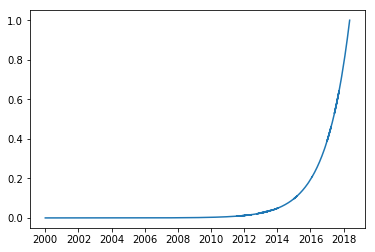

In [112]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(df['date'], weights)

Looks like the weighting is doing roughly what it is supposed to...

In [134]:
from sklearn.metrics import roc_auc_score

def eval_model(lmbda=1.0, halflife=None, prior=0., max_rank=None, include_ranks=False):
    if max_rank is not None:
        _df = df[
            (df['wrank'] < max_rank) &
            (df['lrank'] < max_rank)
        ].copy()
    else:
        _df = df.copy()
        
    mods = []
    out = []
    _df['__weight__'] = 10000 *_get_weights(
        _df['date'].max(),
        _df,
        halflife
    )
    for i in range(len(TIME_BREAKS)):
        cur_break = TIME_BREAKS[i]
        if i + 1 == len(TIME_BREAKS):
            next_break = pd.to_datetime('2099-12-31')
        else:
            next_break = TIME_BREAKS[i + 1]
        print cur_break, next_break
        train_df = _df[_df['date'] < cur_break]
        test_df = _df[
            (_df['date'] >= cur_break) &
            (_df['date'] < next_break)
        ]
        train_X, train_y = get_X_y(train_df, include_ranks=include_ranks)
        test_X, test_y = get_X_y(test_df, include_ranks=include_ranks)
        mod, preds, class_preds = fit_model(
            train_X,
            train_y,
            test_X,
            test_y,
            lmbda=lmbda,
            weights=train_df['__weight__']
        )
        mods.append(mod)
        out.extend(zip(test_df['match_id'].tolist(), preds.tolist(), class_preds.tolist()))
    out_df = pd.DataFrame(out, columns=['match_id', 'pred', 'class_pred'])
    final_df = pd.merge(_df, out_df, on='match_id')

    if max_rank is not None:
        rel = final_df[
            (final_df['lrank'] < max_rank) &
            (final_df['wrank'] < max_rank)
        ]
    else:
        rel = final_df

    auc = roc_auc_score(rel['y'], rel['pred'])
    accuracy = (rel['y'] == rel['class_pred']).mean() 
    print auc, accuracy
    return mods, out, final_df, auc, accuracy 

In [155]:
out = []
for lmbda in [0.001, 0.01, 0.1, 1., 10., 100.]:
    for hl in [45., 90., 180., 365., 730., 1460.]:
        print lmbda, hl
        _, _, _, auc, accuracy = eval_model(lmbda=lmbda, halflife=hl,)
        out.append((lmbda, hl, auc, accuracy))
out

0.001 45.0
2010-01-01 00:00:00 2011-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2011-01-01 00:00:00 2012-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2012-01-01 00:00:00 2013-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2013-01-01 00:00:00 2014-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2014-01-01 00:00:00 2015-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2015-01-01 00:00:00 2016-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2016-01-01 00:00:00 2017-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2017-01-01 00:00:00 2018-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2018-01-01 00:00:00 2099-12-31 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
0.621370793042 0.607097820213
0.001 90.0
2010-01-01 00:00:00 2011-01-01 00:00:00
Fitting model...


Predicting probs...
Predicting classes...
2018-01-01 00:00:00 2099-12-31 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
0.721468234921 0.666141235813
0.01 365.0
2010-01-01 00:00:00 2011-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2011-01-01 00:00:00 2012-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2012-01-01 00:00:00 2013-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2013-01-01 00:00:00 2014-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2014-01-01 00:00:00 2015-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2015-01-01 00:00:00 2016-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2016-01-01 00:00:00 2017-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2017-01-01 00:00:00 2018-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2018-01-01 00:00:00 2099-1

Predicting probs...
Predicting classes...
2017-01-01 00:00:00 2018-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2018-01-01 00:00:00 2099-12-31 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
0.721106418053 0.666951900558
1.0 45.0
2010-01-01 00:00:00 2011-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2011-01-01 00:00:00 2012-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2012-01-01 00:00:00 2013-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2013-01-01 00:00:00 2014-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2014-01-01 00:00:00 2015-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2015-01-01 00:00:00 2016-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2016-01-01 00:00:00 2017-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2017-01-01 00:00:00 2018-01-

Fitting model...
Predicting probs...
Predicting classes...
2016-01-01 00:00:00 2017-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2017-01-01 00:00:00 2018-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2018-01-01 00:00:00 2099-12-31 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
0.697228873854 0.652765267519
10.0 365.0
2010-01-01 00:00:00 2011-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2011-01-01 00:00:00 2012-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2012-01-01 00:00:00 2013-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2013-01-01 00:00:00 2014-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2014-01-01 00:00:00 2015-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2015-01-01 00:00:00 2016-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2016-01-0

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


Predicting probs...
Predicting classes...
2011-01-01 00:00:00 2012-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2012-01-01 00:00:00 2013-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2013-01-01 00:00:00 2014-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2014-01-01 00:00:00 2015-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2015-01-01 00:00:00 2016-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2016-01-01 00:00:00 2017-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2017-01-01 00:00:00 2018-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2018-01-01 00:00:00 2099-12-31 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
0.724998105522 0.668618266979
10.0 1460.0
2010-01-01 00:00:00 2011-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2011-01-01 00:00:00 2012-

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


Predicting probs...
Predicting classes...
2016-01-01 00:00:00 2017-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2017-01-01 00:00:00 2018-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2018-01-01 00:00:00 2099-12-31 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
0.726559333747 0.667717528373
100.0 1460.0
2010-01-01 00:00:00 2011-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2011-01-01 00:00:00 2012-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2012-01-01 00:00:00 2013-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2013-01-01 00:00:00 2014-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2014-01-01 00:00:00 2015-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2015-01-01 00:00:00 2016-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2016-01-01 00:00:00 2017

[(0.001, 45.0, 0.62137079304221166, 0.6070978202125743),
 (0.001, 90.0, 0.67565332710873638, 0.63659700954782927),
 (0.001, 180.0, 0.72088885735482533, 0.66641145739506391),
 (0.001, 365.0, 0.72494540901898019, 0.66884345163033687),
 (0.001, 730.0, 0.72382233659946171, 0.66915871014231665),
 (0.001, 1460.0, 0.7208988611713667, 0.66668167897676089),
 (0.01, 45.0, 0.61922538817729, 0.60660241397946313),
 (0.01, 90.0, 0.66719852001931645, 0.63393983066114212),
 (0.01, 180.0, 0.72146823492109236, 0.66614123581336693),
 (0.01, 365.0, 0.72506710995013834, 0.66897856242118536),
 (0.01, 730.0, 0.72386657083124006, 0.66875337776977117),
 (0.01, 1460.0, 0.72151575507801202, 0.66686182669789229),
 (0.1, 45.0, 0.60652366888389531, 0.58786705098180503),
 (0.1, 90.0, 0.65793223546112001, 0.62961628535399028),
 (0.1, 180.0, 0.72064954464379594, 0.66451990632318503),
 (0.1, 365.0, 0.72593122712833824, 0.66933885786344804),
 (0.1, 730.0, 0.72381621098592674, 0.66897856242118536),
 (0.1, 1460.0, 0.72110

In [157]:
mods, _, _, _, _ = eval_model(lmbda=1.0, halflife=730, max_rank=None, include_ranks=False)

2010-01-01 00:00:00 2011-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2011-01-01 00:00:00 2012-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2012-01-01 00:00:00 2013-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2013-01-01 00:00:00 2014-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2014-01-01 00:00:00 2015-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2015-01-01 00:00:00 2016-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2016-01-01 00:00:00 2017-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2017-01-01 00:00:00 2018-01-01 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
2018-01-01 00:00:00 2099-12-31 00:00:00
Fitting model...
Predicting probs...
Predicting classes...
0.725050534283 0.669113673212


In [158]:
for tb, mod in zip(TIME_BREAKS, mods):
    print '\n' + str(tb)
    print '\n---------------------------'
    print describe_result(mod.beta).head(10)


2010-01-01 00:00:00

---------------------------
      player_idx      coef     player_name
766          766  4.749726      Federer R.
51            51  4.543150        Nadal R.
2              2  4.242827     Djokovic N.
271          271  4.130763       Murray A.
1198        1198  3.835016      Roddick A.
713          713  3.641743  Del Potro J.M.
902          902  3.453878       Agassi A.
1171        1171  3.411859     Tsonga J.W.
345          345  3.403998   Schuettler P.
711          711  3.375832     De Heart R.

2011-01-01 00:00:00

---------------------------
      player_idx      coef     player_name
766          766  4.840985      Federer R.
51            51  4.757687        Nadal R.
2              2  4.301316     Djokovic N.
271          271  4.178260       Murray A.
1198        1198  3.872353      Roddick A.
713          713  3.696683  Del Potro J.M.
1241        1241  3.607979   Nalbandian D.
902          902  3.556751       Agassi A.
287          287  3.539930    Soderling 

#### Naive Model that only uses rank to make class predictions

In [ ]:
df['rank_pred'] = (df['p1_rank'] < df['p2_rank'])
rel_df = df[
    (df['date'] > TIME_BREAKS[0]) &
    df['p1_rank'].notnull() &
    df['p2_rank'].notnull()
]
(rel_df['rank_pred'] == rel_df['y']).mean()

66.6% from using rank alone...but this_updates_constantly and this only looks at matches where both players have rankings...

In [ ]:
# Get year end rankings
rank_df = df.copy()
rank_df['year'] = rank_df['date'].map(lambda x: x.year)
_winner_rank_df = rank_df.groupby(['year', 'winner']).apply(
    lambda x: x[['year', 'winner', 'date', 'wrank']].iloc[-1]
).reset_index(drop=True)
_winner_rank_df.rename(columns={'winner': 'player'}, inplace=True)
_winner_rank_df.rename(columns={'wrank': 'ye_rank'}, inplace=True)

_loser_rank_df = rank_df.groupby(['year', 'loser']).apply(
    lambda x: x[['year', 'loser', 'date', 'lrank']].iloc[-1]
).reset_index(drop=True)
_loser_rank_df.rename(columns={'loser': 'player'}, inplace=True)
_loser_rank_df.rename(columns={'lrank': 'ye_rank'}, inplace=True)

tot_rank_df = pd.concat([_winner_rank_df, _loser_rank_df])
tot_rank_df.sort('date', ascending=True, inplace=True)
year_end_rankings = tot_rank_df.drop_duplicates(['player', 'year'], take_last=True)

In [ ]:
_for_merge = year_end_rankings.copy()
_for_merge['year'] += 1  # Want to match year end rankings for 2000 with matches in 2001

In [ ]:
rank_df = pd.merge(
    rank_df,
    _for_merge,
    left_on=['winner', 'year'],
    right_on=['player', 'year']
)
rank_df.rename(columns={'ye_rank': 'winner_ye_rank'}, inplace=True)

rank_df = pd.merge(
    rank_df,
    _for_merge,
    left_on=['loser', 'year'],
    right_on=['player', 'year']
)
rank_df.rename(columns={'ye_rank': 'loser_ye_rank'}, inplace=True)

In [ ]:
rel_df = rank_df[
    (rank_df['date'] > TIME_BREAKS[0]) &
    rank_df['winner_ye_rank'].notnull() &
    rank_df['loser_ye_rank'].notnull()
]
(rank_df['winner_ye_rank'] < rank_df['loser_ye_rank']).mean()

Only 64% accuracy when we use year-end rankings so apples-to-apples time comparison and can't update rank all the time